In [1]:
%cd Anticipating-Accidents/

/home/dg595/CrashDetection/Azure/Anticipating-Accidents


In [30]:
%%writefile score.py
import json
import numpy as np
import os
import tensorflow as tf
import base64

from PIL import Image
from io import BytesIO

from azureml.core.model import Model
from utils import FeatureExtractor
from accident import build_model

def init():
    global X, feat, sess, soft_pred, all_alphas, keep

    feat = FeatureExtractor(device='cpu')

    tf.reset_default_graph()
    X,keep,y,optimizer,loss,lstm_variables,soft_pred,all_alphas = build_model(batch_size=1)

    model_root = Model.get_model_path('crash-detection')
    saver = tf.train.Saver()

    config=tf.ConfigProto(allow_soft_placement=True)
    config.gpu_options.allow_growth=True
    sess = tf.Session(config=config)
                          
    init = tf.global_variables_initializer()
    sess.run(init)
    saver.restore(sess, os.path.join(model_root, 'model/final_model'))

def load(data):
    data = base64.b64decode(data)
    pil_image = Image.open(BytesIO(data)).convert("RGB")
    # convert to BGR format
    image = np.array(pil_image)[:, :, [2, 1, 0]]
    return image    

def run(raw_data):
    try:
        data = json.loads(raw_data)['data']
        data = load(data)

        # get features
        features, boxes = feat.extract_features([data])
        features, boxes = features[0], np.int64(boxes[0])

#         features = np.expand_dims(np.repeat(features[np.newaxis,...], 100, axis=0), axis=0)
        features = np.expand_dims(np.vstack((features[np.newaxis,...], np.repeat(np.zeros([1,20,1024]), 99, axis=0))), axis=0)

        # make prediction
        [out, weights] = sess.run([soft_pred, all_alphas], feed_dict={X: features, keep: [0.0]})
        y_hat = out #np.argmax(out, axis=1)
#         print("y_hat: ", y_hat)
        return y_hat.tolist(), weights.tolist(), boxes.tolist()

    except Exception as e:
        result = str(e)
        print(result)
        # return error message back to the client
        return {"error": result, "data":raw_data}

Overwriting score.py


In [161]:
# from azureml.core.runconfig import CondaDependencies

# cd = CondaDependencies.create()
# cd.add_conda_package('opencv')
# cd.add_pip_package('torch')
# cd.add_pip_package('torchvision')
# cd.add_tensorflow_conda_package()

# cd.save_to_file(base_directory='./', conda_file_path='myenv.yml')

# print(cd.serialize_to_string())

In [75]:
from azureml.core.webservice import AciWebservice

aciconfig = AciWebservice.deploy_configuration(cpu_cores=2, 
                                               memory_gb=4, 
                                               tags={'name':'CrashDetecton', 'framework': 'TensorFlow DNN'},
                                               description='Tensorflow DNN for Accident Detection',
                                               enable_app_insights=True)

In [4]:
from azureml.core.image import ContainerImage

imgconfig = ContainerImage.image_configuration(execution_script="score.py", 
                                               runtime="python", 
#                                                conda_file="myenv.yml",
                                               dependencies=['utils.py', 'predictor.py', 'accident.py'],
                                                )

In [5]:
# use an image available in a private Container Registry
imgconfig.base_image = "crashdetector.azurecr.io/maskrcnn"
imgconfig.base_image_registry.address = "crashdetector.azurecr.io"
imgconfig.base_image_registry.username = "crashdetector"
imgconfig.base_image_registry.password = "Ycy+YnxoyvYruvORaPl1WqwxWbW7Buu6"

In [ ]:
from azureml.core.webservice import Webservice
from azureml.core import Workspace
from azureml.core.model import Model

ws = Workspace.from_config()
print('Workspace name: ' + ws.name, 
      'Azure region: ' + ws.location, 
      'Subscription id: ' + ws.subscription_id, 
      'Resource group: ' + ws.resource_group, sep='\n')

model = Model(ws, 'crash-detection')

# model.download(target_dir='/Users/Amrut/CrashDetection/CarCrashModel/', exist_ok=True)

# # verify the downloaded model file
# file_path = os.path.join('/Users/Amrut/CrashDetection/CarCrashModel/outputs', "final_model.meta")

# os.stat(file_path)

# Register the image from the image configuration
image = ContainerImage.create(name = "crash-detection",
                              models = [model], #this is the model object
                              image_config = imgconfig,
                              workspace = ws
                              )

image.wait_for_creation(show_output=True)

Found the config file in: /home/dg595/CrashDetection/Azure/Anticipating-Accidents/.azureml/config.json
Workspace name: AccidentDetection
Azure region: eastus
Subscription id: e298a653-a33f-4b32-9ec2-2adfbd3b649d
Resource group: CCGroup7Resources
Creating image
Running.....................................................................................................................

In [50]:
image = ContainerImage.list(ws)[0]

In [204]:
from azureml.core.compute import AksCompute, ComputeTarget
# Set the resource group that contains the AKS cluster and the cluster name
resource_group = 'CCGroup7Resources'
cluster_name = 'crashdetect-aks'

# Attach the cluster to your workgroup
attach_config = AksCompute.attach_configuration(resource_group = resource_group,
                                         cluster_name = cluster_name)
aks_target = ComputeTarget.attach(ws, 'crash-aks', attach_config)

In [206]:
aks_target.wait_for_completion(show_output = True)

Long running operation information not known, unable to poll. Current state is Creating


In [273]:
from azureml.core.webservice import AksWebservice
from azureml.core.compute import AksCompute

aks_target = AksCompute(ws, "crash-aks")

aks_config = AksWebservice.deploy_configuration(cpu_cores = 1, 
                                                memory_gb = 1,
                                                tags={'name':'CrashDetecton', 'framework': 'TensorFlow DNN'},
                                                description='Tensorflow DNN for Accident Detection')

service = Webservice.deploy_from_image(workspace=ws,
                                       name='crash-detection-aks',
                                       deployment_config=aks_config,
                                       deployment_target=aks_target,
                                       image=image)

service.wait_for_deployment(show_output = True)

print(service.state)
print(service.get_logs())

Creating service
Running................
SucceededAKS service creation operation finished, operation "Succeeded"
Healthy
2019-05-05T22:34:07,939788518+00:00 - iot-server/run 
2019-05-05T22:34:07,940675724+00:00 - gunicorn/run 
2019-05-05T22:34:07,941894833+00:00 - rsyslog/run 
2019-05-05T22:34:07,942468237+00:00 - nginx/run 
EdgeHubConnectionString and IOTEDGE_IOTHUBHOSTNAME are not set. Exiting...
2019-05-05T22:34:08,012509742+00:00 - iot-server/finish 1 0
2019-05-05T22:34:08,013554849+00:00 - Exit code 1 is normal. Not restarting iot-server.
Starting gunicorn 19.6.0
Listening at: http://127.0.0.1:9090 (12)
Using worker: sync
worker timeout is set to 300
Booting worker with pid: 48
Could not load the run context. Logging offline
Initializing logger
Starting up app insights client
Starting up request id generator
Starting up app insight hooks
Invoking user's init function
Loading checkpoint from catalog://Caffe2Detectron/COCO/35857890/e2e_faster_rcnn_R-101-FPN_1x
catalog://Caffe2Detect

In [ ]:
service = Webservice.deploy_from_image(workspace=ws,
                                       name='crash-detection-v2',
                                       deployment_config=aciconfig,
                                       image=image)

service.wait_for_deployment(show_output=True)

print(service.get_logs())
print(service.scoring_uri)

In [166]:
# service_name = 'crash-detection'

# # Retrieve existing service
# service = Webservice(name = service_name, workspace = ws)

# # Update the image used by the service
# service.update(image = image) # Note that dash isn't supported in variable names

# print(service.state)

Healthy


In [70]:
print(service.scoring_uri)

None


In [73]:
print(service.get_logs())

2019-05-06T15:37:03,566723261+00:00 - iot-server/run 
2019-05-06T15:37:03,567826761+00:00 - rsyslog/run 
2019-05-06T15:37:03,567929761+00:00 - gunicorn/run 
2019-05-06T15:37:03,576978758+00:00 - nginx/run 
EdgeHubConnectionString and IOTEDGE_IOTHUBHOSTNAME are not set. Exiting...
2019-05-06T15:37:03,699081523+00:00 - iot-server/finish 1 0
2019-05-06T15:37:03,700423223+00:00 - Exit code 1 is normal. Not restarting iot-server.
Starting gunicorn 19.6.0
Listening at: http://127.0.0.1:9090 (15)
Using worker: sync
worker timeout is set to 300
Booting worker with pid: 50
Could not load the run context. Logging offline
Initializing logger
Starting up app insights client
Starting up request id generator
Starting up app insight hooks
Invoking user's init function
Loading checkpoint from catalog://Caffe2Detectron/COCO/35857890/e2e_faster_rcnn_R-101-FPN_1x
catalog://Caffe2Detectron/COCO/35857890/e2e_faster_rcnn_R-101-FPN_1x points to https://dl.fbaipublicfiles.com/detectron/35857890/12_2017_baseli

In [61]:
service.update(auth_enabled = True)

In [9]:
service = Webservice.list(ws)[0]

In [31]:
service.update(memory_gb=8)

TypeError: update() got an unexpected keyword argument 'memory_gb'

In [74]:
service.delete()

In [62]:
primary, secondary = service.get_keys()
print(primary)

Olk5JNn8Ka6Vac92AhDaljdZdtaAfXb6


In [293]:
service.update(enable_app_insights=True)

In [21]:
# TEST DEPLOYMENT #

from PIL import Image
from io import BytesIO

import matplotlib.pyplot as plt
import matplotlib.pylab as pylab
import numpy as np
import requests
import json
import cv2 
import base64

# this makes our figures bigger
pylab.rcParams['figure.figsize'] = 20, 12

def load(url):
    """
    Given an url of an image, downloads the image and
    returns a PIL image
    """
    response = requests.get(url)
    pil_image = Image.open(BytesIO(response.content)).convert("RGB")
    # convert to BGR format
    image = np.array(pil_image)[:, :, [2, 1, 0]]
    return image

def imshow(img):
    plt.imshow(img[:, :, [2, 1, 0]])
    plt.axis("off")

In [41]:
url = 'https://ncadvertiser.com/wp-content/uploads/sites/82/2018/04/Cop-Car-Crash-close.jpg'

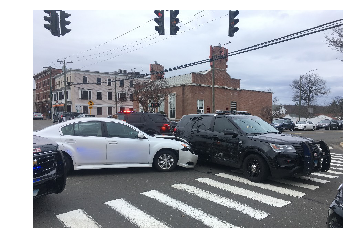

In [42]:
image = load(url)
imshow(image)

In [43]:
img_str = cv2.imencode('.jpg', image)[1].tostring()
img_str = base64.b64encode(img_str)
img_str = img_str.decode("utf-8")

In [ ]:
%%time
result = service.run(test_image)

In [48]:
test_image = json.dumps({'data': img_str})
test_image = bytes(test_image, encoding='utf8')

scoring_uri = 'http://52.224.200.104:80/score'
key = 'Jm1FpbSnMcuro6i7GM0OgF1HIK8Y52VI'

# Set the content type
headers = { 'Content-Type':'application/json' }
# If authentication is enabled, set the authorization header
headers['Authorization']=f'Bearer {key}'

In [ ]:
# Make the request and display the response
res = requests.post(scoring_uri, test_image, headers = headers)
result = res.text

In [ ]:
result = eval(result)
prob, weight, boxes = result
weight, boxes = np.array(weight), np.array(boxes)

In [284]:
np.max(np.array(prob))

0.4376775324344635

In [179]:
def show_plot(frame, weight, bboxes):
    counter = 0
    
    new_weight = weight[:,:,0]*255
    attention_frame = np.zeros((frame.shape[0],frame.shape[1]),dtype = np.uint8)
    now_weight = new_weight[counter,:]
    new_bboxes = bboxes[:,:]
    index = np.argsort(now_weight)
    print(index)
    
    for num_box in index:
            
        if now_weight[num_box]/255.0>0.4:
            cv2.rectangle(frame,(new_bboxes[num_box,0],new_bboxes[num_box,1]),(new_bboxes[num_box,2],new_bboxes[num_box,3]),(0,255,0),3)
        else:
            cv2.rectangle(frame,(new_bboxes[num_box,0],new_bboxes[num_box,1]),(new_bboxes[num_box,2],new_bboxes[num_box,3]),(255,0,0),2)
            
        font = cv2.FONT_HERSHEY_SIMPLEX
        cv2.putText(frame,str(round(now_weight[num_box]/255.0*10000)/10000),(new_bboxes[num_box,0],new_bboxes[num_box,1]), font, 0.5,(0,0,255),1,cv2.LINE_AA)
        attention_frame[int(new_bboxes[num_box,1]):int(new_bboxes[num_box,3]),int(new_bboxes[num_box,0]):int(new_bboxes[num_box,2])] = now_weight[num_box]

    attention_frame = cv2.applyColorMap(attention_frame, cv2.COLORMAP_HOT)
    dst = cv2.addWeighted(frame,0.6,attention_frame,0.4,0)
    cv2.putText(dst,str(counter+1),(10,30), font, 1,(255,255,255),3)
    return dst

[ 0  5  4  9  2 15 13 17 16 18 12  6  3 14  7 11  1 10  8]


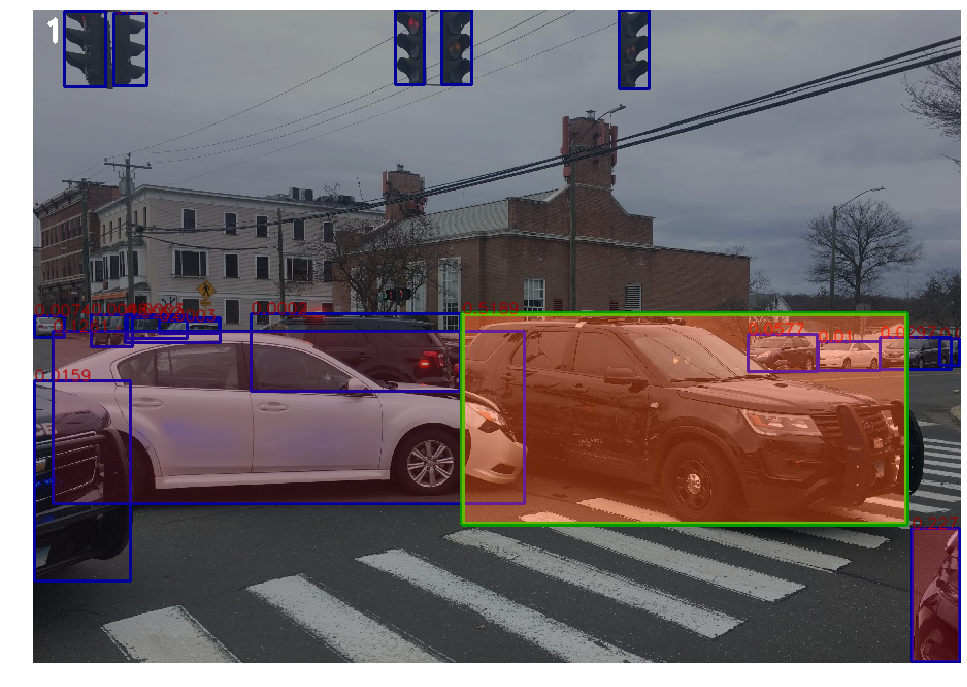

In [180]:
final_img = np.array(image.copy())
final_img = show_plot(final_img, weight, boxes)
imshow(final_img)